# Pix2Pix
Using the cGAN architecture of Pix2Pix to develop a RGB --> NIR image translation model.

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2024-01-05 21:55:22.425142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset
We are using a browsing dataset intended for inspection and not full training. We are using this dataset to test the model and see if it can be used for our purposes.
[Source](https://www.epfl.ch/labs/ivrl/research/downloads/rgb-nir-scene-dataset/)

In [2]:
dataset_path = pathlib.Path("../nirscene0/jpg1") # fullsize concatenated pairs

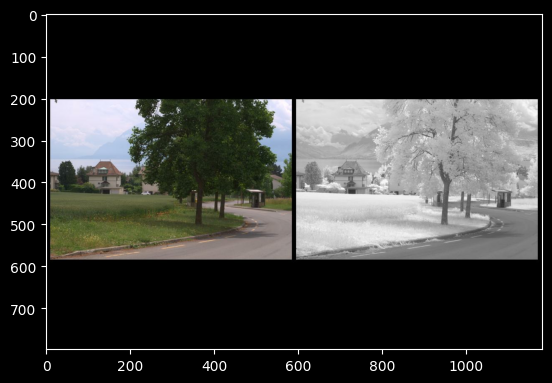

In [3]:
image_data = tf.io.read_file(str(dataset_path/"country_0000.jpg"))
image = tf.io.decode_jpeg(image_data)
plt.imshow(image.numpy())

We need to take one tensor and split into two from the middle. We will use the first half as the input and the second half as the desired output.

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

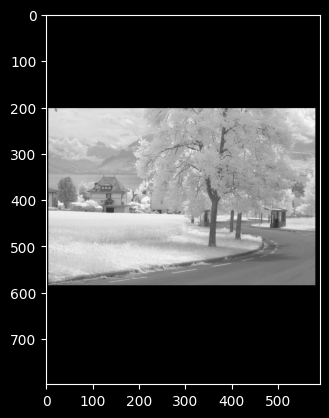

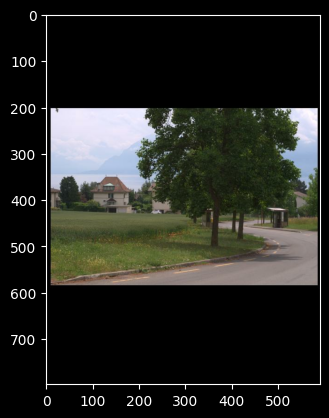

In [5]:
inp, re = load(str(dataset_path / "country_0000.jpg"))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [6]:
inp.shape

TensorShape([798, 591, 3])

## Splitting

Gather the images

In [7]:
image_paths = list(dataset_path.glob('*.jpg'))
image_paths = [str(path) for path in image_paths]
image_paths = tf.random.shuffle(image_paths) # shuffle the order of all image paths for decent distribution
image_paths = image_paths.numpy().tolist()

image_paths[:10]

[b'../nirscene0/jpg1/field_0023.jpg',
 b'../nirscene0/jpg1/indoor_0056.jpg',
 b'../nirscene0/jpg1/indoor_0001.jpg',
 b'../nirscene0/jpg1/field_0042.jpg',
 b'../nirscene0/jpg1/street_0047.jpg',
 b'../nirscene0/jpg1/country_0044.jpg',
 b'../nirscene0/jpg1/field_0031.jpg',
 b'../nirscene0/jpg1/field_0040.jpg',
 b'../nirscene0/jpg1/field_0011.jpg',
 b'../nirscene0/jpg1/forest_0013.jpg']

In [8]:
dataset_directory = "../nirscene0/dataset"
train_directory = os.path.join(dataset_directory, "train")
test_directory = os.path.join(dataset_directory, "test")

# Create dataset directory and its subdirectories
os.makedirs(dataset_directory, exist_ok=True)
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

In [9]:
train_image_paths = image_paths[: int(len(image_paths) * 0.8)]
test_image_paths = image_paths[int(len(image_paths) * 0.8) :]

for path in train_image_paths:
    image_data = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image_data)
    path = path.decode("utf-8")
    tf.io.write_file(
        "../nirscene0/dataset/train/" + path.split("/")[-1], tf.io.encode_jpeg(image)
    )

for path in test_image_paths:
    image_data = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image_data)
    path = path.decode("utf-8")
    tf.io.write_file(
        "../nirscene0/dataset/test/" + path.split("/")[-1], tf.io.encode_jpeg(image)
    )

len(train_image_paths), len(test_image_paths) # split distribution

(381, 96)

## Preprocessing
We need to apply random jittering to the training set to make it more robust. We will also need to normalize the images to the range [-1, 1] to make it easier for the model to learn.

In [10]:
BUFFER_SIZE = 381
BATCH_SIZE = 1

IMG_WIDTH = 798
IMG_HEIGHT = 591

Below are the ops we will use for preprocessing.

In [11]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_WIDTH, IMG_HEIGHT, 3]
    )

    return cropped_image[0], cropped_image[1]

In [13]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

Below I deviate from the guide as cropping after resizing based on original image size is not possible. I will crop first and then resize.

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286) 

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

Here is what the preprocessing pipeline looks like:

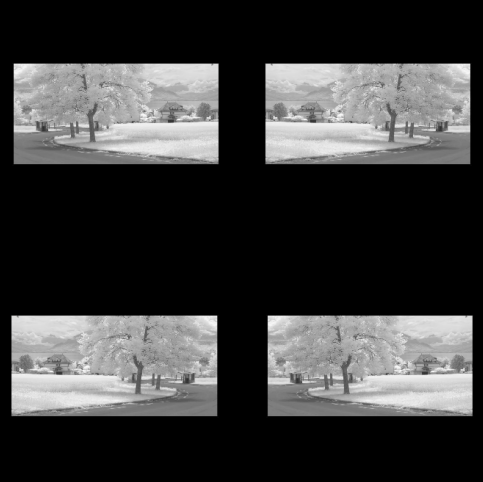

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

## Loading the images

In [16]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [17]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [18]:
train_dataset = tf.data.Dataset.list_files('../nirscene0/dataset/train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
test_dataset = tf.data.Dataset.list_files("../nirscene0/dataset/test/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Generator

Encoder definition

In [20]:
OUTPUT_CHANNELS = 3


def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 399, 296, 3)


Decoder definition

In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [23]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 798, 592, 3)


In [24]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[798, 591, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # Adjust the dimensions of skip to match x
        skip = tf.image.resize(skip, tf.shape(x)[1:3], method="nearest")
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

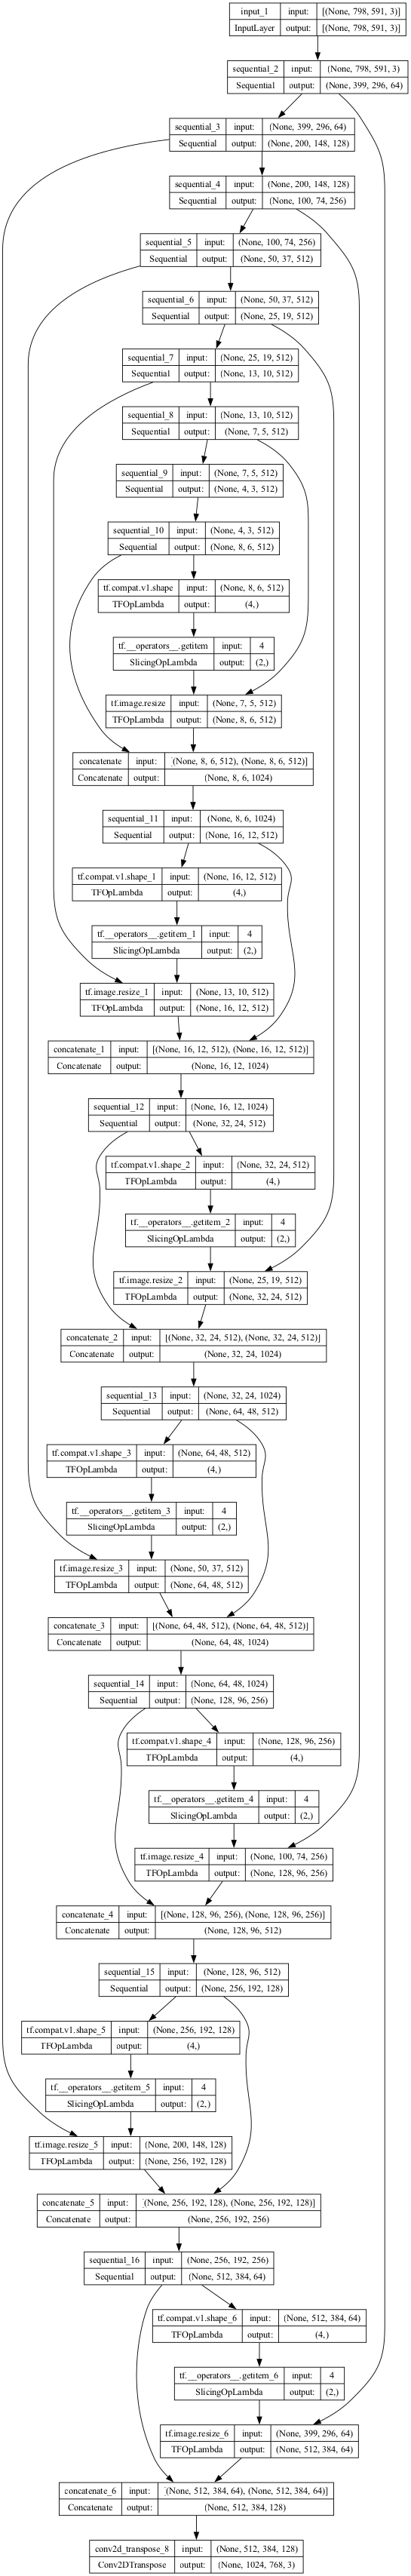

In [25]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


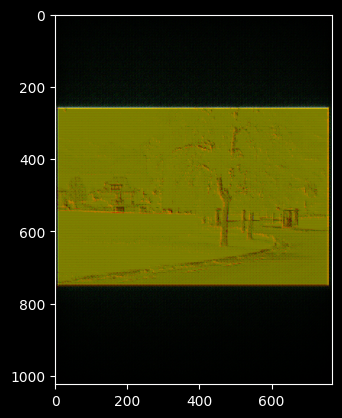

In [26]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Losses
Structured loss such that the generator learns to produce images that are indistinguishable from the real images by the discriminator.

In [27]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Discriminator

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(shape=[798, 591, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[798, 591, 3], name="target_image")

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 798, 591, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 399, 295, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 199, 147, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 99, 73, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 101, 75, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(
        zero_pad1
    )  # (batch_size, 98, 72, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 100, 74, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        zero_pad2
    )  # (batch_size, 97, 71, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


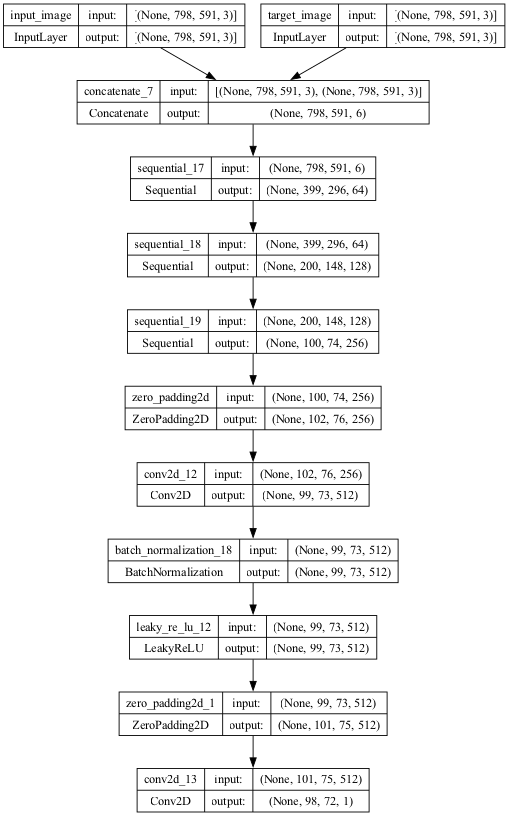

In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)